### Step 0: Import Dependencies

In [1]:
from fastcore.all import *
from fastai.vision.all import *

In [2]:
torch.cuda.is_available()

False

In [3]:
# This code is only here to check that your internet is enabled. It doesn't do anything else.

import socket, warnings
try:
    socket.setdefaulttimeout(5)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

### Step 1: Download Pictures of Plastic Debri and People and Ocean Wildlife

In [4]:
from duckduckgo_search import DDGS #ddg_images


def search_images(term, max_images=60):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')

In [16]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('marine animal', max_images=1)
print(len(urls))
urls[0]

Searching for 'marine animal'
1


'https://www.thoughtco.com/thmb/9dAKSuC7_bmSutA72DTvXX0cEas=/2122x1415/filters:no_upscale():max_bytes(150000):strip_icc()/sea-otter-heatherwest-getty-56a5f7bf3df78cf7728abf39.jpg'

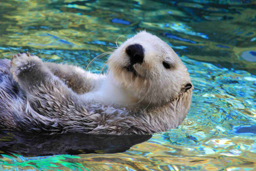

In [17]:
from fastdownload import download_url
dest = 'test_pictures/marine animal.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256) 

In [7]:
categories  = ['plastic debri', 'people']

In [8]:
for i in categories:
    download_url(search_images(f'{i}', max_images=1)[0], f'test_pictures/{i}.jpg', show_progress=False)

Searching for 'plastic debri'
Searching for 'people'


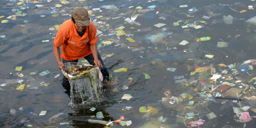

In [9]:
Image.open('test_pictures/plastic debri.jpg').to_thumb(256,256)

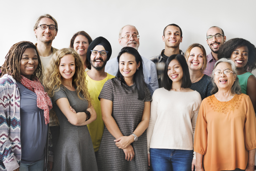

In [14]:
Image.open('test_pictures/people.jpg').to_thumb(256,256)

In [10]:
categories.append('marine animal')

In [11]:
searches = categories
path = Path('marine_train_images')

In [19]:
print(searches)

['plastic debri', 'people', 'marine animal']


In [20]:
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} floating on water'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} under water'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'plastic debri'


### Step 2: Model Training

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

In [ ]:
marine_debri_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.25, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms(1.5)
).dataloaders(path, bs=32)

marine_debri_data.train.show_batch(max_n=5, nrows=1, unique=True)

In [ ]:
marine_debri_data.train.show_batch(max_n=15, nrows=3, unique=False)

### Traning A Fine Tuned Model 

In [ ]:
learn = vision_learner(marine_debri_data, arch=resnet34, metrics=error_rate)
learn.fine_tune(4)

### Error Interpretation

In [ ]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(4, nrows=2)

In [ ]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
br- 

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

In [ ]:
marine_debri_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.25, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
).dataloaders(path, bs=32)

marine_debri_data.train.show_batch(max_n=5, nrows=1, unique=True)

In [ ]:
learn = vision_learner(marine_debri_data, arch=resnet34, metrics=error_rate)
learn.fine_tune(3)

### Saving The Model

In [ ]:
learn.export('marine_learner.pkl')

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

In [ ]:
learn_inf = load_learner(path/'marine_learner.pkl')

In [ ]:
learn_inf.predict('test_pictures/waste plastic.jpg')